# Propensity Score Matching (PSM) Analysis

This notebook performs a Propensity Score Matching (PSM) analysis to estimate the Conditional Average Treatment Effect (CATE) for two hypotheses, denoted as `p` and `k`. The analysis involves several steps, including data loading, preprocessing, propensity score estimation, matching, and evaluation of the results.

## Data Loading and Preprocessing

The data is loaded and preprocessed using custom scripts from benchmark_data_scripts.

In [27]:
from scripts.benchmark_data_scripts.data_preprocessing import load_data, preprocess_data

training_data, ground_truth = load_data(path="../../data/benchmark_data")
meta_learner_data = preprocess_data(training_data, ground_truth)

# Define feature columns, outcome, treatment, and true CATE for each hypothesis
covariates = [ "AnswerValue", "CorrectAnswer", "QuestionSequence", "ConstructId"]
treatment_col = "Treatment"
meta_learner_data.head()


number of null rows in iscorrect column :QuizSessionId       0
AnswerId            0
UserId              0
QuizId              0
QuestionId          0
IsCorrect           0
AnswerValue         0
CorrectAnswer       0
QuestionSequence    0
ConstructId         0
Type                0
Timestamp           0
dtype: int64


C:\Users\dell\OneDrive\Desktop\Thesis\CATE_Estimation_using_Meta_Learners\scripts\benchmark_data_scripts\data_preprocessing.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  treatment_group["Treatment"] = 1
C:\Users\dell\OneDrive\Desktop\Thesis\CATE_Estimation_using_Meta_Learners\scripts\benchmark_data_scripts\data_preprocessing.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_group["Treatment"] = 0


,Treatment,IsCorrect,AnswerValue,CorrectAnswer,QuestionSequence,ConstructId,TrueCATE_p,TrueCATE_k
682,1,0.0,1.0,4.0,2,3133,-0.107143,-0.083333
683,1,0.0,4.0,2.0,2,3133,-0.107143,-0.083333
684,1,1.0,4.0,4.0,4,3133,-0.107143,-0.083333
685,1,1.0,4.0,4.0,1,3133,-0.107143,-0.083333
686,1,1.0,3.0,3.0,2,3133,-0.107143,-0.083333


## Propensity Score Estimation

Propensity scores are estimated using logistic regression.

In [28]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

# Define covariates, treatment column, and outcome column
covariates = ["AnswerValue", "CorrectAnswer", "QuestionSequence", "ConstructId"]
treatment_col = "Treatment"

# Load the dataset (ensure it's preprocessed)
data = meta_learner_data


# Step 2: Estimate the propensity score using logistic regression
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(data[covariates], data[treatment_col])
data['propensity_score'] = logistic_model.predict_proba(data[covariates])[:, 1]

# Step 3: Perform Propensity Score Matching (PSM) - Nearest Neighbor Matching
treated = data[data[treatment_col] == 1]
control = data[data[treatment_col] == 0]

# Nearest neighbor matching
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Match treated individuals with control individuals
matched_control = control.iloc[indices.flatten()].reset_index(drop=True)
matched_treated = treated.reset_index(drop=True)


## Propensity Score Matching (PSM)

Nearest Neighbor Matching is performed to match treated and control individuals based on their propensity scores and CATE for both hypotheses `p` and `k` is estimated.

In [29]:
# Step 4: Estimate CATE for PSM
outcome_col = "TrueCATE_k"

cate_k = matched_treated[outcome_col] - matched_control[outcome_col]
print(f"Estimated Average CATE (PSM): {cate_k.mean()}")

# Save CATE estimates to a CSV file
cate_df = pd.DataFrame({'CATE': cate_k})
cate_df.to_csv('../../results/benchmark_data_results/psm_results/cate_psm.csv', index=False)

Estimated Average CATE (PSM): 0.3183941992894737


In [30]:
outcome_col = "TrueCATE_p"
# Step 4: Estimate CATE for PSM
cate_p = matched_treated[outcome_col] - matched_control[outcome_col]
print(f"Estimated Average CATE (PSM): {cate_p.mean()}")

# Save CATE estimates to a CSV file
cate_df = pd.DataFrame({'CATE': cate_p})
cate_df.to_csv('../../results/benchmark_data_results/psm_results/cate_psm.csv', index=False)

Estimated Average CATE (PSM): 0.24594522007894737


## Evaluation Metrics

The Root Mean Squared Error (RMSE), bias, and variance are calculated for both hypotheses

In [31]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Extract ground truth CATE values for both hypotheses
true_cate_p = matched_treated['TrueCATE_p'].reset_index(drop=True)
true_cate_k = matched_treated['TrueCATE_k'].reset_index(drop=True)

# RMSE Calculation
rmse_p = np.sqrt(mean_squared_error(true_cate_p, cate_p))
rmse_k = np.sqrt(mean_squared_error(true_cate_k, cate_k))

# Bias Calculation
bias_p = np.mean(cate_p - true_cate_p)
bias_k = np.mean(cate_k - true_cate_k)

# Variance Calculation
variance_p = np.var(cate_p)
variance_k = np.var(cate_k)

# Print Evaluation Results
print(f"Evaluation Metrics for Hypothesis P:")
print(f"  RMSE: {rmse_p}")
print(f"  Bias: {bias_p}")
print(f"  Variance: {variance_p}")

print(f"\nEvaluation Metrics for Hypothesis K:")
print(f"  RMSE: {rmse_k}")
print(f"  Bias: {bias_k}")
print(f"  Variance: {variance_k}")


Evaluation Metrics for Hypothesis P:
  RMSE: 0.107142857
  Bias: 0.10714285699999995
  Variance: 0.015051266280859805

Evaluation Metrics for Hypothesis K:
  RMSE: 0.083333333
  Bias: 0.08333333300000002
  Variance: 0.025224731950623518


 * For Hypothesis P, the RMSE of 0.1071 indicates a moderate level of accuracy in estimating the true CATE values. The bias of 0.1071 suggests a slight overestimation of the predicted CATE relative to the ground truth. The variance of 0.0151 indicates that the predicted CATE values are relatively consistent, showing lower variability compared to earlier calculations.
 * For Hypothesis K, the RMSE of 0.0833 is slightly higher than that of Hypothesis P, indicating a marginally reduced accuracy. The bias of 0.0833 indicates a slight overestimation in predicted values, while the variance of 0.0252 demonstrates slightly higher variability in predictions as well than Hypothesis P.

## Visualization

The distribution of the estimated CATE versus the true CATE is visualized using KDE plots.

C:\Users\dell\AppData\Local\Temp\ipykernel_6612\3033289492.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cate_p, label="PSM-Estimated CATE", color="blue", shade=True)
C:\Users\dell\AppData\Local\Temp\ipykernel_6612\3033289492.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(true_cate_p, label="True CATE (P)", color="orange", shade=True)


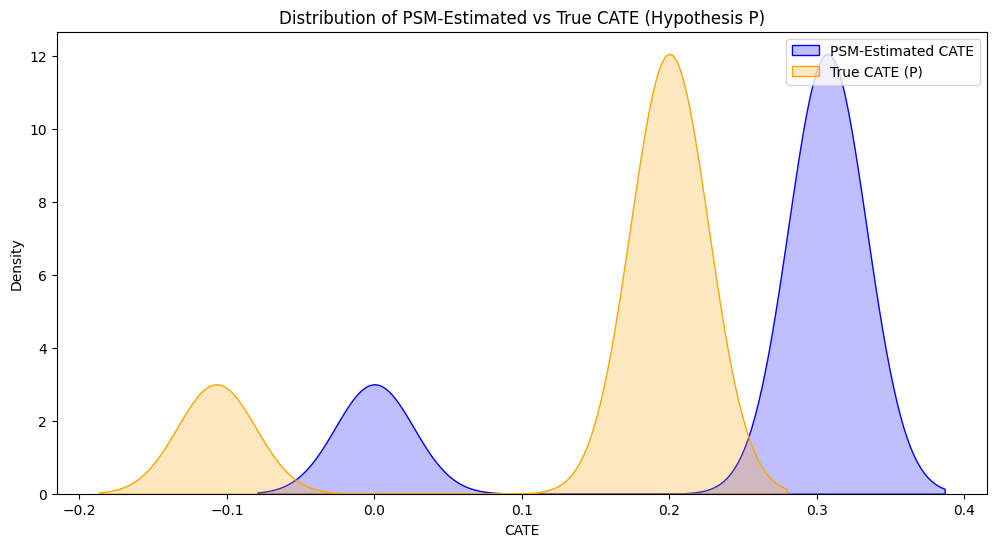

In [32]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.kdeplot(cate_p, label="PSM-Estimated CATE", color="blue", shade=True)
sns.kdeplot(true_cate_p, label="True CATE (P)", color="orange", shade=True)
plt.title("Distribution of PSM-Estimated vs True CATE (Hypothesis P)")
plt.xlabel("CATE")
plt.legend()
plt.show()


C:\Users\dell\AppData\Local\Temp\ipykernel_6612\3166414909.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cate_k, label="PSM-Estimated CATE", color="blue", shade=True)
C:\Users\dell\AppData\Local\Temp\ipykernel_6612\3166414909.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(true_cate_k, label="True CATE (k)", color="orange", shade=True)


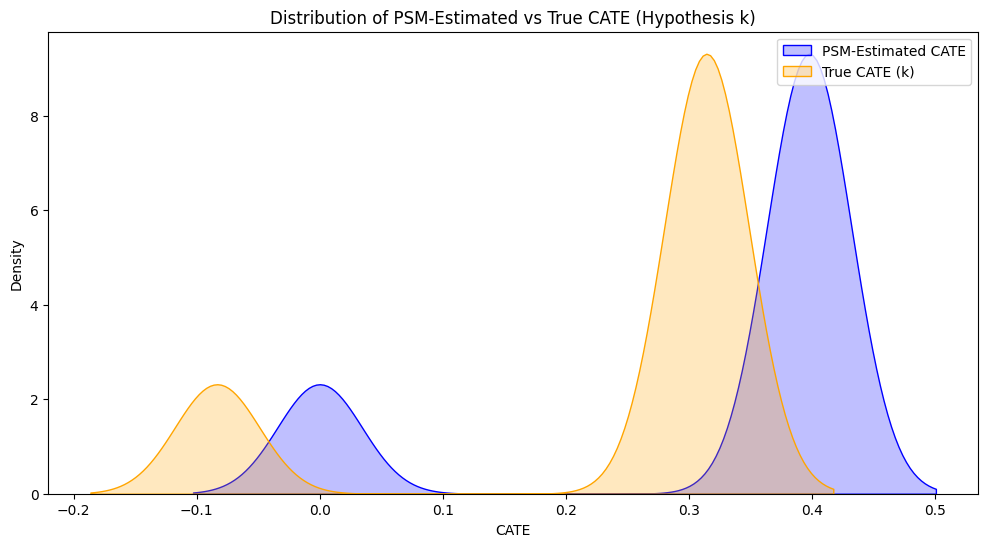

In [33]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.kdeplot(cate_k, label="PSM-Estimated CATE", color="blue", shade=True)
sns.kdeplot(true_cate_k, label="True CATE (k)", color="orange", shade=True)
plt.title("Distribution of PSM-Estimated vs True CATE (Hypothesis k)")
plt.xlabel("CATE")
plt.legend()
plt.show()


The density distributions of the PSM-estimated CATE and the true CATE for both hypothesis. Propensity Score Matching (PSM)-estimated CATE distributions (blue curves) exhibit a consistent positive bias, with their centers positioned closer to zero compared to the true CATE distributions (orange curves), which are shifted toward positive values around 0.2 and 0.3, respectively. This deviation indicates that PSM tends to understate the true treatment effects. Additionally, the PSM-estimated distributions show a broader spread than the true distributions, reflecting higher variability and reduced precision in the estimates. While there is partial overlap between the estimated and true distributions for both hypotheses, the peaks remain misaligned, with the estimated values failing to accurately capture the concentration of true CATE values around their respective peaks.